# Datathon - Machine Learning

A continuacion vamos a implementar el modelo de machine learning para predecir si un envio llegará a tiempo o no. 

En primer lugar vamos a cargar los datos y a eliminar las columnas que no vamos a usar (Segun el analisis exploratorio de los datos EDA).

In [398]:
import pandas as pd

#cargo la info al dataframe
df = pd.read_excel("E-Commerce_train.xlsx") 

#Elimino las columnas que no voy a utilizar.
df.drop("ID", axis=1, inplace=True)
df.drop("Warehouse_block", axis=1, inplace=True)
df.drop("Customer_rating", axis=1, inplace=True)
df.drop("Prior_purchases", axis=1, inplace=True)
df.drop("Gender", axis=1, inplace=True)
df.drop("Product_importance", axis=1, inplace=True)

#imprimo el dataframe
df.head()

,Mode_of_Shipment,Customer_care_calls,Cost_of_the_Product,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,Flight,4,177,44,1233,1
1,Flight,4,216,59,3088,1
2,Flight,2,183,48,3374,1
3,Flight,3,176,10,1177,1
4,Flight,2,184,46,2484,1


In [421]:
#Convierto la variable categorica de la columna Modo de envios
MS = pd.get_dummies(df["Mode_of_Shipment"], prefix='MS')
data=pd.concat([MS, df], axis=1) #concateno las tablas
data.drop("Mode_of_Shipment", axis=1, inplace=True) #elimino la columna "Mode_of_Shipment" porque ya no la necesito

#imprimo el resultado
data.head()


,MS_Flight,MS_Road,MS_Ship,Customer_care_calls,Cost_of_the_Product,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,0,0,4,177,44,1233,1
1,1,0,0,4,216,59,3088,1
2,1,0,0,2,183,48,3374,1
3,1,0,0,3,176,10,1177,1
4,1,0,0,2,184,46,2484,1


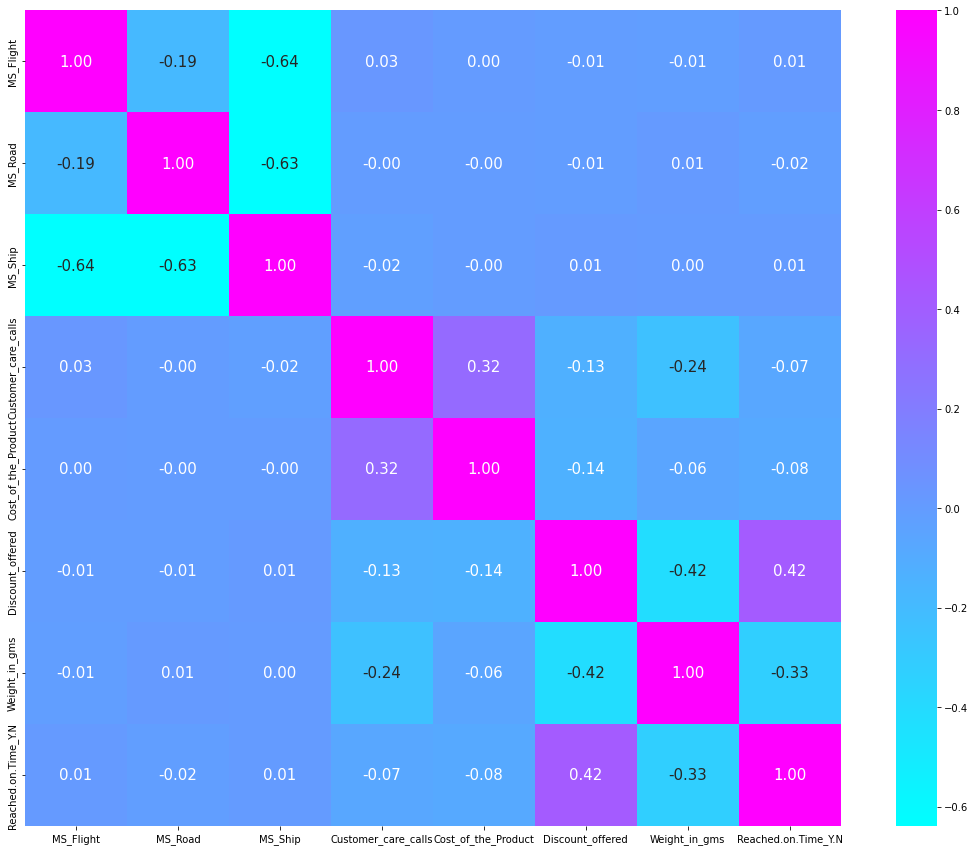

In [422]:
# Hacemos un mapa de calor para ver la correlacion entre las variables
import matplotlib.pyplot as plt
import seaborn as sns

correlacion = data.corr()
plt.figure(figsize=(20,15))
sns.heatmap(correlacion, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15}, xticklabels= data.columns, yticklabels= data.columns, cmap= 'cool')
plt.show()

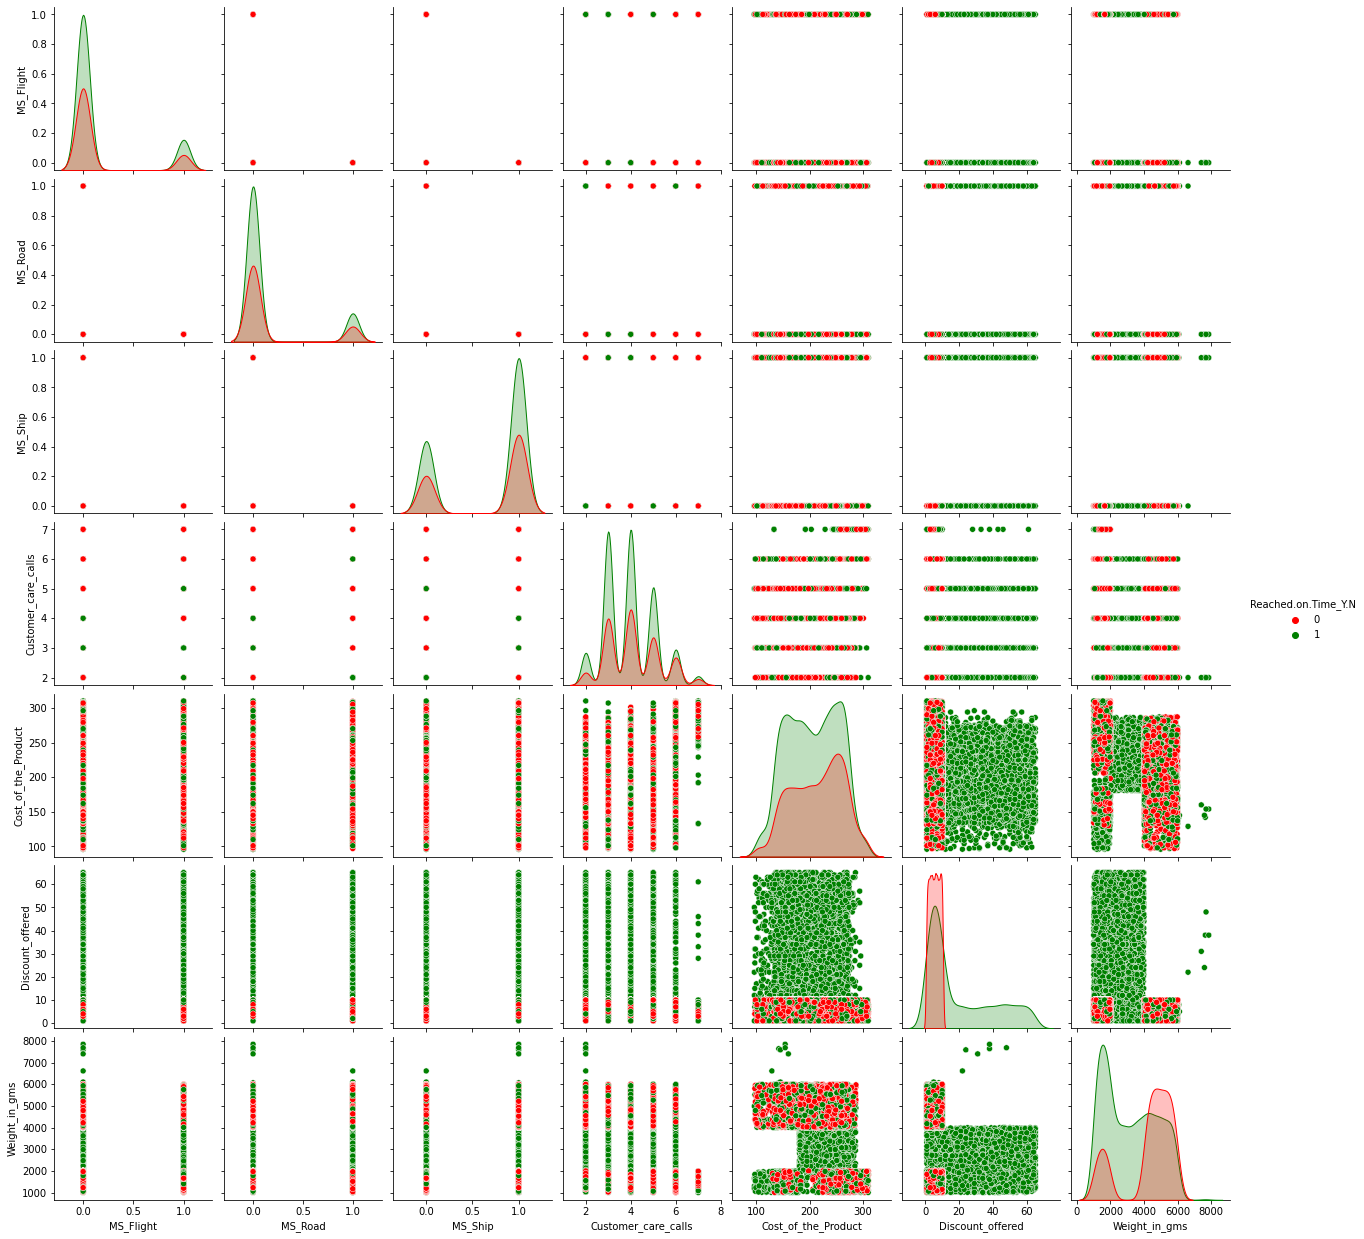

In [423]:
#Hacemos un pair plot para ver las correlaciones entre las variables
sns.pairplot(data=data, hue="Reached.on.Time_Y.N", palette = ['r', 'g'])
plt.show()

In [424]:
#Cargamos los datos a las variables X e Y

X = data.iloc[:, 0:-1].values
Y = data.iloc[:, -1].values

In [425]:
#separamos los datos para entrenar y testear

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42, stratify = y)

In [426]:
# Importamos las librerías necesarias para hacer los pipelines

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import sklearn.metrics as metrics

In [427]:
# Creamos los pipelines, estandarizamos los datos segun sea necesario

pipe_LR = Pipeline([('scl', StandardScaler()), ('clf', LogisticRegression())])
pipe_RFC = Pipeline([('clf', RandomForestClassifier(n_estimators=150, n_jobs=-1))])
pipe_BC = Pipeline([('scl', StandardScaler()), ('clf', BaggingClassifier(bootstrap_features=False, n_estimators= 150, n_jobs = -1))])
pipe_DTC = Pipeline([('clf', DecisionTreeClassifier(max_depth=2, criterion='entropy'))])
pipe_KNN = Pipeline([('scl', StandardScaler()), ('clf', KNeighborsClassifier())])
pipe_SVC = Pipeline([('scl', StandardScaler()), ('clf', SVC(kernel='rbf', random_state=0))])

In [428]:
#Entrenamos los modelos

pipe_LR.fit(X_train, y_train)
pipe_RFC.fit(X_train, y_train)
pipe_BC.fit(X_train, y_train)
pipe_DTC.fit(X_train, y_train)
pipe_KNN.fit(X_train, y_train)
pipe_SVC.fit(X_train, y_train)

Pipeline(steps=[('scl', StandardScaler()), ('clf', SVC(random_state=0))])

In [429]:
#Vemos el score de cada modelo

print("Regresion Logaritmica Score:" , pipe_LR.score(X_test, y_test))
print("Random Forest Score:" , pipe_RFC.score(X_test, y_test))
print("Bagging Classifier Score:" , pipe_BC.score(X_test, y_test))
print("Arbol de decision Score:" , pipe_DTC.score(X_test, y_test))
print("KNN Score:" , pipe_KNN.score(X_test, y_test))
print("SVC Score:" , pipe_SVC.score(X_test, y_test))

Regresion Logaritmica Score: 0.6764444444444444
Random Forest Score: 0.6777777777777778
Bagging Classifier Score: 0.6648888888888889
Arbol de decision Score: 0.7026666666666667
KNN Score: 0.6746666666666666
SVC Score: 0.6955555555555556


In [ ]:
#El puntaje mas alto lo obtuvo el "ARBOL DEDECISION", vamos a trabajar con ese modelo

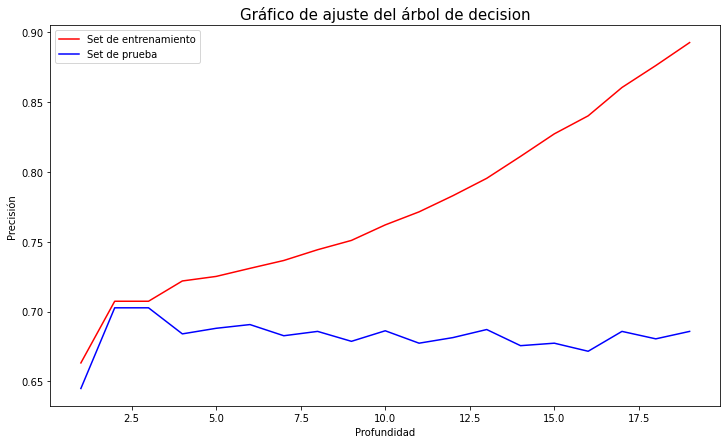

In [431]:
#Nos aseguramos que la cantidad de ramificaciones del arbol sea la correcta

entrenamiento =  []
prueba = []
ramas = list(range(1, 20))

for i in ramas:
    DTC = DecisionTreeClassifier(max_depth=i, criterion='entropy')
    DTC.fit(X_train, y_train)
    entrenamiento.append(DTC.score(X_train, y_train))
    prueba.append(DTC.score(X_test, y_test))

plt.figure(figsize=(12,7))
plt.plot(ramas, entrenamiento, color='r', label='Set de entrenamiento')
plt.plot(ramas, prueba, color='b', label='Set de prueba')
plt.title('Gráfico de ajuste del árbol de decision', fontsize = 15)
plt.legend()
plt.ylabel('Precisión')
plt.xlabel('Profundidad')
plt.show()

In [442]:
#Observamos que con 3 ramificaciones obtenemos la mayor precision
#Instanciamos el modelo
DTC = DecisionTreeClassifier(max_depth=3, criterion='entropy')
#Entrenamos el modelo
DTC.fit(X_train, y_train)
#Predecimos
y_pred = DTC.predict(X_test)
#vemos la precision
from sklearn.metrics import accuracy_score
print("La presicion de nuestro modelo es:", round(accuracy_score(y_test,y_pred),2))

La presicion de nuestro modelo es: 0.7


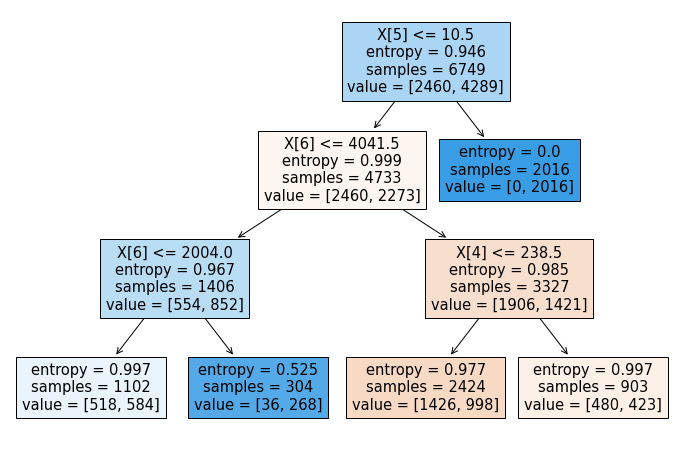

In [443]:
#Vemos como trabaja nuestro arbol
from sklearn import tree
plt.figure(figsize = (12,8))
tree.plot_tree(DTC, filled = True)
plt.show()

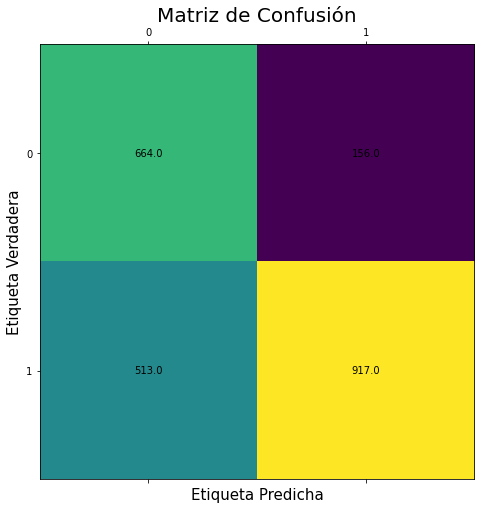

In [445]:
# Creamos la Matriz de confusión 
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(12,8))
ax.matshow(cm)
plt.title('Matriz de Confusión', fontsize=20)
plt.ylabel('Etiqueta Verdadera', fontsize=15)
plt.xlabel('Etiqueta Predicha', fontsize=15)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

In [447]:
# Reporte de Clasificacion

from sklearn.metrics import classification_report

reporte = classification_report(y_test, y_pred)
print("Reporte de Clasificación:")
print(reporte)

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.56      0.81      0.66       820
           1       0.85      0.64      0.73      1430

    accuracy                           0.70      2250
   macro avg       0.71      0.73      0.70      2250
weighted avg       0.75      0.70      0.71      2250



Pasamos a cargar los datos de testeo del archivo E-commerce_test.xlsx para crear el archico"csv" que se debe entregar

In [448]:
#cargo la info al dataframe
df_prueba = pd.read_excel("E-Commerce_test.xlsx") 

#imprimo el dataframe
df_prueba.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms
0,9000,F,Ship,5,1,189,2,medium,M,10,5248
1,9001,D,Ship,5,3,150,2,high,F,9,4446
2,9002,F,Ship,3,3,200,3,low,M,3,5739
3,9003,A,Ship,5,1,133,2,medium,M,1,4643
4,9004,B,Ship,4,2,260,3,low,M,4,5504


In [449]:
#Elimino las columnas que no voy a utilizar.

df_prueba.drop("ID", axis=1, inplace=True)
df_prueba.drop("Warehouse_block", axis=1, inplace=True)
df_prueba.drop("Customer_rating", axis=1, inplace=True)
df_prueba.drop("Prior_purchases", axis=1, inplace=True)
df_prueba.drop("Gender", axis=1, inplace=True)
df_prueba.drop("Product_importance", axis=1, inplace=True)

#imprimo el dataframe
df_prueba.head()

,Mode_of_Shipment,Customer_care_calls,Cost_of_the_Product,Discount_offered,Weight_in_gms
0,Ship,5,189,10,5248
1,Ship,5,150,9,4446
2,Ship,3,200,3,5739
3,Ship,5,133,1,4643
4,Ship,4,260,4,5504


In [450]:
#Convierto la variable categorica de la columna Modo de envios
MSp = pd.get_dummies(df_prueba["Mode_of_Shipment"], prefix='MS')
data_prueba=pd.concat([MSp, df_prueba], axis=1) #concateno las tablas
data_prueba.drop("Mode_of_Shipment", axis=1, inplace=True) #elimino la columna "Mode_of_Shipment" porque ya no la necesito

data_prueba.head()

,MS_Flight,MS_Road,MS_Ship,Customer_care_calls,Cost_of_the_Product,Discount_offered,Weight_in_gms
0,0,0,1,5,189,10,5248
1,0,0,1,5,150,9,4446
2,0,0,1,3,200,3,5739
3,0,0,1,5,133,1,4643
4,0,0,1,4,260,4,5504


In [451]:
#Cargo todos los datos a mi set de prueba

X_prueba = data_prueba.iloc[:,:].values

In [452]:
# Predecimos
YPRED = DTC.predict(X_prueba)

In [453]:
#Vemos el resultado
YPRED

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [456]:
data_final=pd.DataFrame(YPRED, columns=["pred"])
data_final

,pred
0,0
1,0
2,0
3,0
4,0
...,...
1995,1
1996,1
1997,1
1998,1


In [458]:
#Exportamos el dataframe resultante a "csv"

data_final.to_csv("hcaneva.csv", index=False)

## EN EL ARCHIVO DATATHON(EDA) SE ENCUENTRA EL ANALISIS PREVIO DE LOS DATOS